# visualise_results.py
 Visualise metrics for classic models (exclude CNN). Reads JSONs from artifacts/.


In [1]:

import os, json
import numpy as np
import matplotlib.pyplot as plt

# ---- config ----
ART = r"D:\LocalUser\42177 Project\artifacts"
MODELS = ["logreg", "svm", "knn", "tree", "rf", "xgb"]  # no 'cnn'
METRICS = ["Accuracy", "Precision", "Recall", "F1"]


In [2]:


# ---- i/o helpers ----
def load_json_result(model: str, suffix: str = "clean"):
    path = os.path.join(ART, f"results_{model}_{suffix}.json")
    if not os.path.exists(path):
        return None
    with open(path) as f:
        return json.load(f)


def load_many(models, suffix="clean"):
    out = {}
    for m in models:
        r = load_json_result(m, suffix=suffix)
        if r is not None:
            out[m] = r
    return out



In [3]:

# ---- plotting ----
def bar_plot(results: dict, metric: str, title_suffix: str = "Clean"):
    names = [m.upper() for m in results.keys()]
    vals = [results[m][metric] for m in results.keys()]
    plt.figure(figsize=(7, 4))
    plt.bar(names, vals)
    plt.ylim(0, 1)
    plt.title(f"{metric} — {title_suffix}")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm: np.ndarray, labels: list, title: str):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha="right")
    plt.yticks(tick_marks, labels)
    # annotate
    thresh = cm.max() if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = int(cm[i, j])
            color = "white" if thresh and val > thresh * 0.6 else "black"
            plt.text(j, i, str(val), ha="center", va="center", color=color, fontsize=8)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


In [4]:
# ---- 1) load clean results (exclude CNN) ----
results_clean = load_many(MODELS, suffix="clean")
if not results_clean:
    raise SystemExit("No clean results JSONs found in artifacts/.")


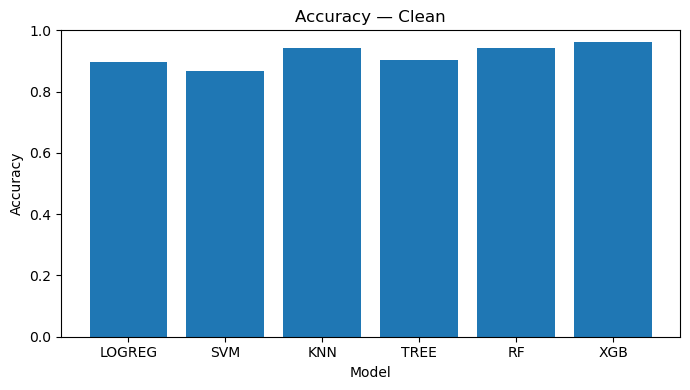

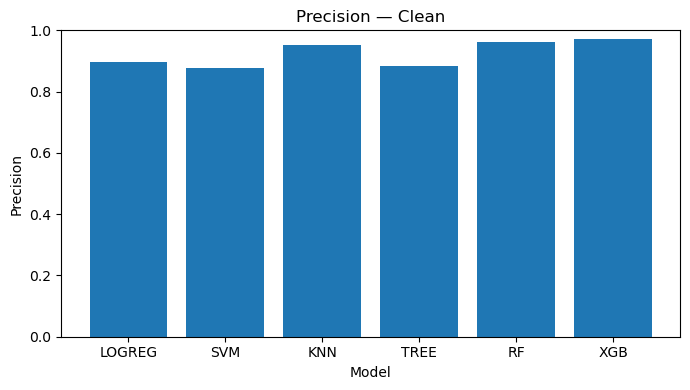

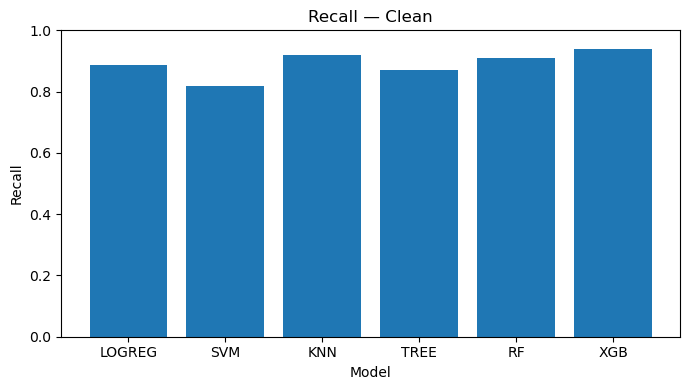

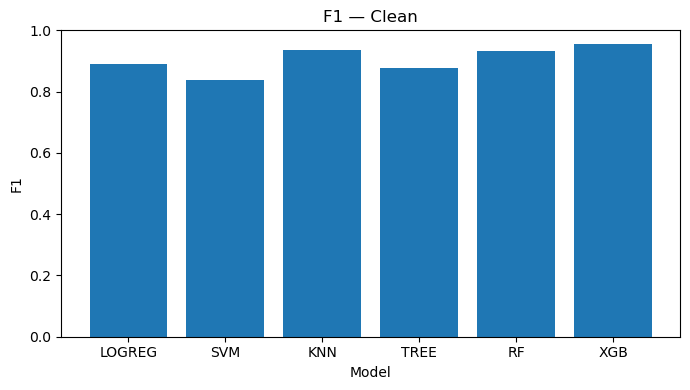

In [5]:

# ---- 2) bar charts for clean metrics ----
for metric in METRICS:
    bar_plot(results_clean, metric, title_suffix="Clean")


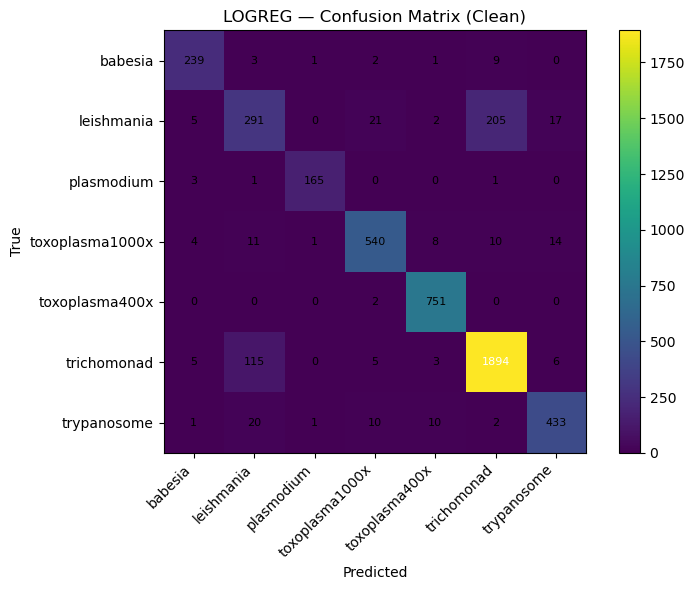

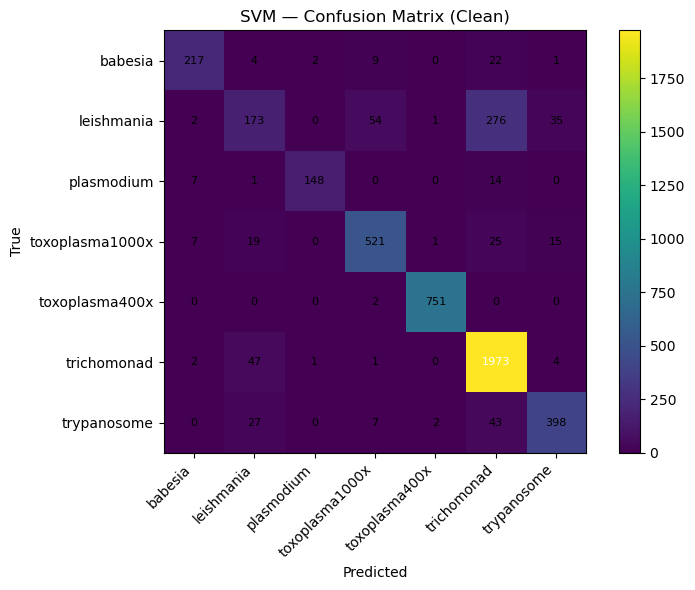

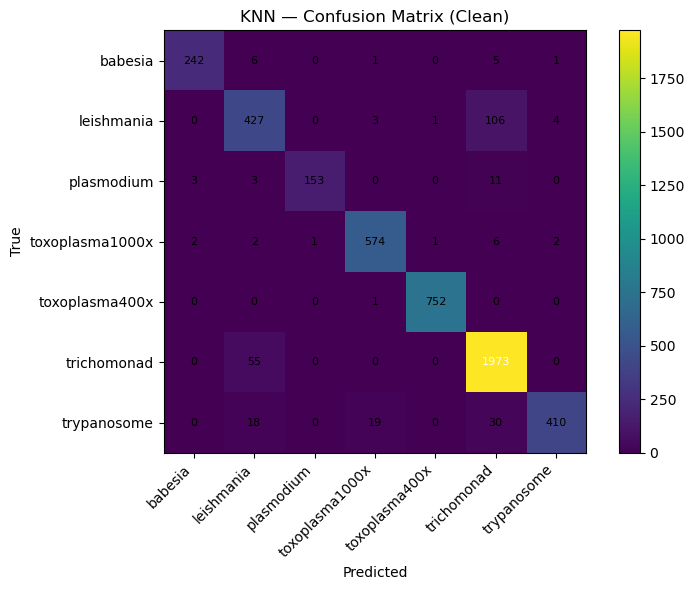

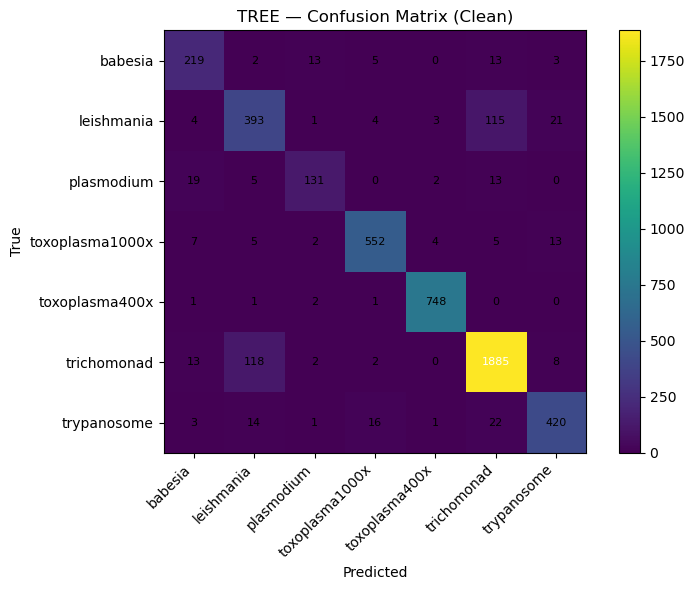

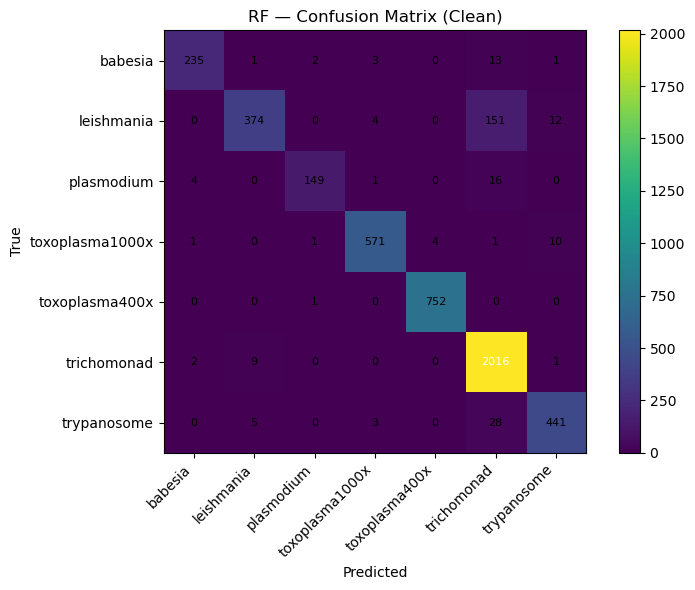

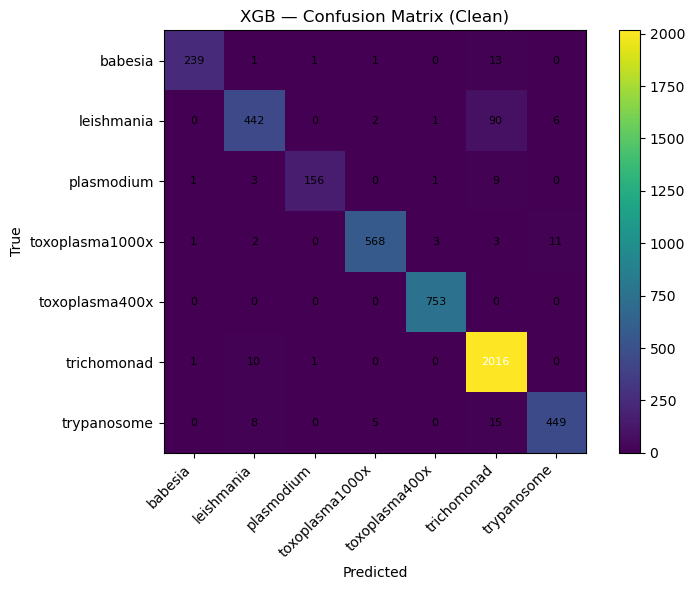

In [13]:
# ---- 3) show ALL models' confusion matrices (clean) ----
for m, r in results_clean.items():
    cm = np.array(r["ConfusionMatrix"])
    labels = r["Labels"]
    title = f"{m.upper()} — Confusion Matrix (Clean)"
    plot_confusion_matrix(cm, labels, title)


In [ ]:
# ---- 5) summary table in console ----
print("\n=== Summary (Clean) ===")
for m in results_clean:
    r = results_clean[m]
    print(f"{m.upper():6s} | Acc: {r['Accuracy']:.3f}  "
          f"Prec: {r['Precision']:.3f}  Rec: {r['Recall']:.3f}  F1: {r['F1']:.3f}")


=== Summary (Clean) ===
LOGREG | Acc: 0.896  Prec: 0.898  Rec: 0.886  F1: 0.891
SVM    | Acc: 0.869  Prec: 0.876  Rec: 0.819  F1: 0.838
KNN    | Acc: 0.942  Prec: 0.954  Rec: 0.921  F1: 0.936
TREE   | Acc: 0.904  Prec: 0.882  Rec: 0.871  F1: 0.876
RF     | Acc: 0.943  Prec: 0.962  Rec: 0.911  F1: 0.933
XGB    | Acc: 0.961  Prec: 0.972  Rec: 0.939  F1: 0.955


### robustness test results

In [ ]:
# Generate robustness summary table (Acc / F1 (ΔAcc)) from saved JSON results
# Saves CSV to ART/robust_results_overview_table.csv (no markdown print)
import os, json, math
import numpy as np
import pandas as pd

# ---- config ----
ART = r"D:\LocalUser\42177 Project\artifacts"
MODELS = ["knn", "xgb", "tree", "rf", "svm", "logreg", "cnn"]  # order matching template
METRIC_ACC = "Accuracy"
METRIC_F1 = "F1"

# Degradations in table order and expected suffix patterns (we allow filename variants)
DEGRADATIONS = [
    ("clean", ["clean"]),
    ("Resolution loss — down 2×", ["resolution_x2", "resolution_down_2x", "resolution_down_2×", "resolution_down_2"]),
    ("Resolution loss — down 4×", ["resolution_x4", "resolution_down_4x", "resolution_down_4×", "resolution_down_4"]),
    ("Gaussian blur s = 1.0", ["gaussian_blur_s1.0", "gaussian_blur_s1", "gaussian_blur_s_1.0"]),
    ("Gaussian blur s = 2.0", ["gaussian_blur_s2.0", "gaussian_blur_s2", "gaussian_blur_s_2.0"]),
    ("Motion blur k = 5", ["motion_blur_k5", "motion_blur_k_5"]),
    ("Motion blur k = 10", ["motion_blur_k10", "motion_blur_k_10"]),
    ("Gaussian noise s = 5", ["gaussian_noise_s5", "gaussian_noise_s_5"]),
    ("JPEG quality = 60", ["jpeg_q60", "jpeg_quality_60"]),
    ("JPEG quality = 40", ["jpeg_q40", "jpeg_quality_40"]),
    ("JPEG quality = 20", ["jpeg_q20", "jpeg_quality_20"]),
]

# Helper to load JSON result for model and a list of suffix candidates
def load_json_result_variants(model: str, suffix_variants):
    for suffix in suffix_variants:
        fname = f"results_{model}_{suffix}.json"
        path = os.path.join(ART, fname)
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as f:
                try:
                    return json.load(f)
                except Exception:
                    # skip unreadable file variant
                    continue
    return None

# Collect clean baseline for deltas
clean_results = {}
for m in MODELS:
    r = load_json_result_variants(m, ["clean"])
    if r:
        try:
            clean_results[m] = {
                METRIC_ACC: float(r.get(METRIC_ACC, math.nan)),
                METRIC_F1: float(r.get(METRIC_F1, math.nan))
            }
        except Exception:
            clean_results[m] = {METRIC_ACC: math.nan, METRIC_F1: math.nan}

# Build table rows
rows = []
for deg_label, suffix_list in DEGRADATIONS:
    row = {"Degradation / Level": deg_label}
    for m in MODELS:
        r = load_json_result_variants(m, suffix_list)
        if r is None:
            cell = "N/A"
        else:
            try:
                acc = float(r.get(METRIC_ACC, math.nan))
                f1 = float(r.get(METRIC_F1, math.nan))
            except Exception:
                acc, f1 = math.nan, math.nan
            if m in clean_results and not math.isnan(clean_results[m][METRIC_ACC]) and not math.isnan(acc):
                delta_acc = acc - clean_results[m][METRIC_ACC]
                cell = f"{acc*100:.2f}% / {f1*100:.2f}% ({delta_acc*100:+.2f}%)"
            elif not math.isnan(acc):
                cell = f"{acc*100:.2f}% / {f1*100:.2f}%"
            else:
                cell = "N/A"
        row[m.upper()] = cell
    rows.append(row)

# Create pandas DataFrame and save CSV
df = pd.DataFrame(rows)
cols = ["Degradation / Level"] + [m.upper() for m in MODELS]
df = df[cols]

out_csv = os.path.join(ART, "robust_results_overview_table.csv")
df.to_csv(out_csv, index=False)
print(f"Saved CSV: {out_csv}")

Saved CSV: D:\LocalUser\42177 Project\artifacts\robust_results_overview_table.csv
